# 💻 Guia de Prática 7 💻

### 👉 Passos iniciais:

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
@author: Erick Nathan M. Alves & Victor Sidnei Cotta
@data: 16/11/2022
"""



#Importando as bibliotecas:
import numpy as np # importando biblioteca numpy
import matplotlib.pyplot as plt # importando biblioteca para plotar as figuras
import control as ct  #importando biblioteca python control systems

plt.close('all') #comando para fechar todas janelas de plot

#Exibição dos gráficos em janela externa:
#%matplotlib qt
#Exibição dos gráficos em no notebook:
%matplotlib inline



#Parâmetros do sistema:
La = .154
L1 = .155
Lt = .270
d = .02
mt = .005
rho = 1.23
c = 2.05
mi = 5
g = 9.81

#Constantes do modelo:
K1 = ((d*rho*c*La*L1)/(2*mt*(((Lt**2)/12)+(d**2))))
K2 = ((g*d)/(((Lt**2)/12)+(d**2)))
K3 = ((mi*d**2)/(mt*(((Lt**2)/12)+(d**2))))

#Dinâmica do sistema:
X0 = [0, 0] #condições iniciais

#Caracterizando o modelo, em espaço de estados:
def model_update(t, x, u, params):
    
    x1 = x[0] # posicao
    x2 = x[1] # velocidade
    M = u[1] # massa variável
    u = u[0] # sinal de controle

    #Constantes do modelo:
    C1 = ((d*rho*c*La*L1)/(2*M*(((Lt**2)/12)+(d**2))))
    C2 = ((g*d)/(((Lt**2)/12)+(d**2)))
    C3 = ((mi*d**2)/(M*(((Lt**2)/12)+(d**2))))

    #Retorna as derivadas:
    return [x2, ((C1*(np.cos(x1)**2)*u) - ((C2*np.sin(x1)) + (C3*x2)))]

#Função que retorna o estado:
def model_output(t, x, u, params):
    return x

#Instanciando o sistema:
fanplate = ct.NonlinearIOSystem(model_update, model_output, states=2, name='fanplate', inputs=('u', 'u_m'), outputs=('x1','x2'))

#Definições importantes:
pop = 27 #Ponto de operação
u_eq = (((K2/K1)*np.sin(np.radians(pop)))/(np.cos(np.radians(pop))**2)) #sinal que leva ao ponto desejado
Ad = 5 #amplitude do degrau utilizado na sintonia do controlador
ud = (((K2/K1)*np.sin(np.radians(pop+Ad)))/(np.cos(np.radians(pop+Ad))**2)) #sinal usado na sintonia do controlador
s = ct.tf('s')

### 👉 Item 1:

* Definição do atraso de 4s:

In [2]:
#Duração do atraso:
delay = 4
#Aproximação de padé:
o_p = 5
N = ct.pade(delay, o_p)
#Função de transferência do atraso:
Gd = ct.TransferFunction(np.array(N[0]), np.array(N[1]))
print(f'\n Gd: \t {Gd}')
#Transformando a FT em um sistema de entradas e saídas:
atraso = ct.tf2io(Gd, name='atraso', inputs='u', outputs='y')


 Gd: 	 
-s^5 + 7.5 s^4 - 26.25 s^3 + 52.5 s^2 - 59.06 s + 29.53
-------------------------------------------------------
s^5 + 7.5 s^4 + 26.25 s^3 + 52.5 s^2 + 59.06 s + 29.53



* Obtenção dos controladores P - Ziegler Nichols e PI - CHR, vide Guia 6:

In [3]:
#Parâmetros via resposta ao degrau (Guia 6) + atraso de 4 segundos:
k = (np.radians(Ad)/(ud-u_eq))
theta = delay
tau = 1.5212

#Controlador P - Ziegler Nichols:
Kc_p = (tau/(k*theta))
ft_p = ct.tf(Kc_p, 1)
sys_p = ct.tf2io(ft_p, name='cp', inputs='u', outputs='y')
omega_p = 7.3732

#Controlador PI - Ziegler Nichols:
Kc_pi = ((0.6*tau)/(k*theta))
Ti_pi = (4*theta)
ft_pi1 = ct.tf(Kc_pi, 1) # PI - Ziegler Nichols (Parte Proporcional)
ft_pi2 = (Kc_pi/(Ti_pi*s)) # PI - Ziegler Nichols (Parte Integral)
sys_pi1 = ct.tf2io(ft_pi1, name='cpi1', inputs='u', outputs='y')
sys_pi2 = ct.tf2io(ft_pi2, name='cpi2', inputs='u', outputs='y')
omega_pi = 5.9132

* Condições de simulação para validação em degraus:

In [4]:
#Condições iniciais:
X0 = np.hstack((np.zeros(o_p), np.radians(pop), 0))
#Tempo para alcançar o ponto de operação:
top = 200
#Array de tempo:
t = np.arange(0, top+3200, .01)
#Sinal de equilíbrio:
u0 = u_eq*np.ones(t.shape)
#Massa constante:
mc = mt*np.ones(t.shape)
#Preparando o sinal de referência:
r0 = [0, 1, 0, -1, 0.5, 1, -0.5, 0]
tdeg = 400 #duração de cada degrau
rs = []
rs.append(np.radians(pop)*np.ones(top*100))
for i in range(len(r0)):
    ri = np.radians(pop+(Ad*r0[i]))
    rs.append(ri*np.ones(tdeg*100))
r = np.hstack(rs)

* Simulação da malha fechada com controlador P - Ziegler Nichols:

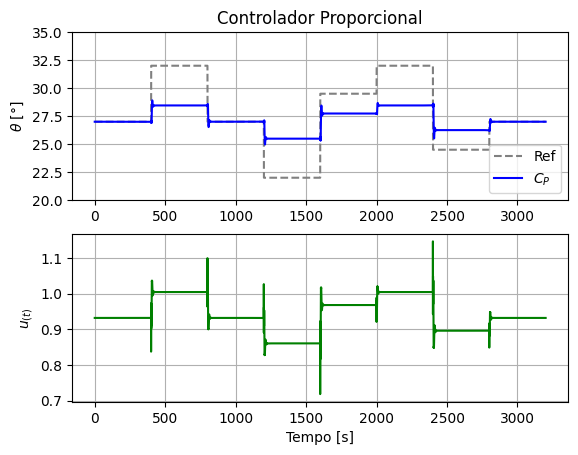

In [5]:
#Conexão da malha fechada:
closed_loop1 = ct.InterconnectedSystem(
    (fanplate, atraso, sys_p), name='closed_loop1', 
    connections=(('cp.u', '-fanplate.x1'), ('atraso.u', 'cp.y'), ('fanplate.u', 'atraso.y')), 
    inplist=('cp.u', 'atraso.u', 'fanplate.u_m'),
    inputs=('xref', 'u0', 'u_m'),
    outlist=('fanplate.x1', 'fanplate.x2', 'fanplate.u'),
    outputs=('x1', 'x2', 'u')
)



# Simulando Malha Fechada:
t, xout = ct.input_output_response(closed_loop1, t, [r, u0, mc], X0)
cp = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(1)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(t[(top*100):]-top, np.degrees(r[(top*100):]), 'gray', linestyle='dashed', label='Ref')
plt.plot(t[(top*100):]-top, np.degrees(cp[(top*100):]),'blue',label='$C_P$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.title('Controlador Proporcional')
plt.ylim(20, 35)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t[(top*100):]-top, xout[2][(top*100):], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

* Simulação da malha fechada com controlador PI - CHR:

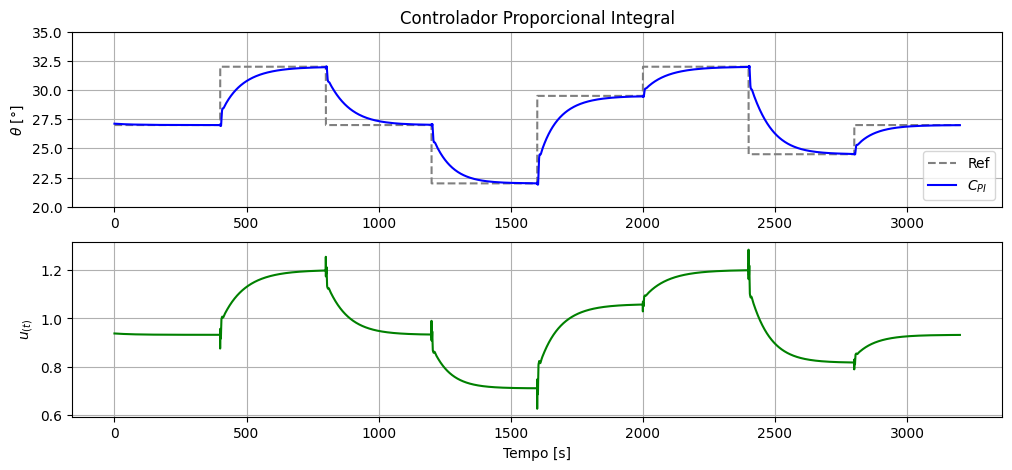

In [6]:
#Conexão da malha fechada:
closed_loop2 = ct.InterconnectedSystem(
    (fanplate, atraso, sys_pi1, sys_pi2), name='closed_loop2', 
    connections=(('cpi1.u', '-fanplate.x1'), ('atraso.u', 'cpi1.y'), ('cpi2.u', '-fanplate.x1'), ('atraso.u', 'cpi2.y'), ('fanplate.u', 'atraso.y')), 
    inplist=('cpi1.u', 'cpi2.u', 'atraso.u', 'fanplate.u_m'),
    inputs=('xref1', 'xref2', 'u0', 'u_m'),
    outlist=('fanplate.x1', 'fanplate.x2', 'fanplate.u'),
    outputs=('x1', 'x2', 'u')
)

# Simulando Malha Fechada:
t, xout = ct.input_output_response(closed_loop2, t, [r, r, u0, mc], X0)
cpi = xout[0]

#Plotando o resultado da simulação-------------------------------------------------------------------
plt.figure(2)
plt.rcParams['figure.figsize'] = (12, 5)
plt.subplot(2, 1, 1)
plt.plot(t[(top*100):]-top, np.degrees(r[(top*100):]), 'gray', linestyle='dashed', label='Ref')
plt.plot(t[(top*100):]-top, np.degrees(cpi[(top*100):]),'blue',label='$C_{PI}$')
plt.ylabel('$\\theta$ [°]')
plt.legend(loc='lower right')
plt.title('Controlador Proporcional Integral')
plt.ylim(20, 35)
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(t[(top*100):]-top, xout[2][(top*100):], 'green', label='$u_{(t)}$')
plt.ylabel('$u_{(t)}$')
plt.xlabel('Tempo [s]')
plt.grid()
plt.show()

### 👉 Item 2:

* Análise de Ganho e Sensitividade para o Controlador Proporcional:

In [7]:
#Ganho de malha:
Gc = ft_p #ganho do controlador
#Via aproximação para modelo de primeira ordem, vide guia 5:
G = ((k*(np.exp(-theta*1j*omega_p)))/((tau*s)+1))#*Gd
L = Gc*G
print('\nGanho de malha L(s):')
print(L)

#Sensitividade:
S = (1/(1+L))
print('\nSensitividade S(s):')
print(S)

#Sensitividade complementar:
C = (L/(1+L))
print('\nSensitividade Complementar C(s):')
print(C)


Ganho de malha L(s):

  -0.3803
-----------
1.521 s + 1


Sensitividade S(s):

  1.521 s + 1
----------------
1.521 s + 0.9392


Sensitividade Complementar C(s):

     -0.5785 s - 0.3803
----------------------------
2.314 s^2 + 2.894 s + 0.9392



* Análise de Ganho e Sensitividade para o Controlador Proporcional Integral:

In [8]:
#Ganho de malha:
Gc = (ft_pi1+ft_pi2) #ganho do controlador
#Via aproximação para modelo de primeira ordem, vide guia 5:
G = ((k*(np.exp(-theta*1j*omega_p)))/((tau*s)+1))#*Gd
L = Gc*G
print('\nGanho de malha L(s):')
print(L)

#Sensitividade:
S = (1/(1+L))
print('\nSensitividade S(s):')
print(S)

#Sensitividade complementar:
C = (L/(1+L))
print('\nSensitividade Complementar C(s):')
print(C)


Ganho de malha L(s):

-3.651 s - 0.2282
-----------------
24.34 s^2 + 16 s


Sensitividade S(s):

      24.34 s^2 + 16 s
----------------------------
24.34 s^2 + 15.13 s - 0.2282


Sensitividade Complementar C(s):

     -88.86 s^3 - 63.97 s^2 - 3.651 s
-------------------------------------------
592.4 s^4 + 752.8 s^3 + 241.5 s^2 - 3.651 s



### 👉 Item 3:

* Erro de Rastreamento:

In [9]:
#Como neste caso não há sinal de perturbação, nem ruído de medição, pela equação (5), Guia 7:
E = S*

SyntaxError: invalid syntax (3635026659.py, line 2)

### 👉 Item 7:

* Definindo as condições de simulação:

In [19]:
# Parâmetros de tempos:
timp = 0.01 #duração do impulso
tdeg = 200 #duração do degrau

#Array de tempo:
t = np.arange(0, ((6*tdeg)+(timp)), .01)

#Criação do sinal de controle:
Aimp = 8 #amplitude do impulso
Adeg = 3 #amplitude do degrau
uop = (((K2/K1)*np.sin(np.radians(pop)))/(np.cos(np.radians(pop))**2))*np.ones(int(tdeg*100)) #sinal que aplica o degrau
uimp = (((K2/K1)*np.sin(np.radians(pop+Aimp)))/(np.cos(np.radians(pop+Aimp))**2))*np.ones(int(timp*100)) #sinal que aplica o imulso
udeg = (((K2/K1)*np.sin(np.radians(pop+Adeg)))/(np.cos(np.radians(pop+Adeg))**2))*np.ones(int(tdeg*100)) #sinal que aplica o degrau
u = np.concatenate((uop, uimp, uop, udeg, uop, uop, uop))

#Vetor de massa:
m1 = 

0.932057300722871


* Inserção de impulso, degrau e variação de massa - Controlador Proporcional:

* Inserção de impulso, degrau e variação de massa - Controlador Proporcional Integral: